Step [10/1000], Loss: 0.0322
Step [20/1000], Loss: 0.0223
Step [30/1000], Loss: 0.0222
Step [40/1000], Loss: 0.0222
Step [50/1000], Loss: 0.0222
Step [60/1000], Loss: 0.0222
Step [70/1000], Loss: 0.0222
Step [80/1000], Loss: 0.0222
Step [90/1000], Loss: 0.0222
Step [100/1000], Loss: 0.0222
Step [110/1000], Loss: 0.0222
Step [120/1000], Loss: 0.0222
Step [130/1000], Loss: 0.0222
Step [140/1000], Loss: 0.0222
Step [150/1000], Loss: 0.0222
Step [160/1000], Loss: 0.0222
Step [170/1000], Loss: 0.0222
Step [180/1000], Loss: 0.0223
Step [190/1000], Loss: 0.0223
Step [200/1000], Loss: 0.0223
Step [210/1000], Loss: 0.0223
Step [220/1000], Loss: 0.0223
Step [230/1000], Loss: 0.0223
Step [240/1000], Loss: 0.0223
Step [250/1000], Loss: 0.0223
Step [260/1000], Loss: 0.0223
Step [270/1000], Loss: 0.0223
Step [280/1000], Loss: 0.0223
Step [290/1000], Loss: 0.0223
Step [300/1000], Loss: 0.0223
Step [310/1000], Loss: 0.0223
Step [320/1000], Loss: 0.0223
Step [330/1000], Loss: 0.0224
Step [340/1000], Lo

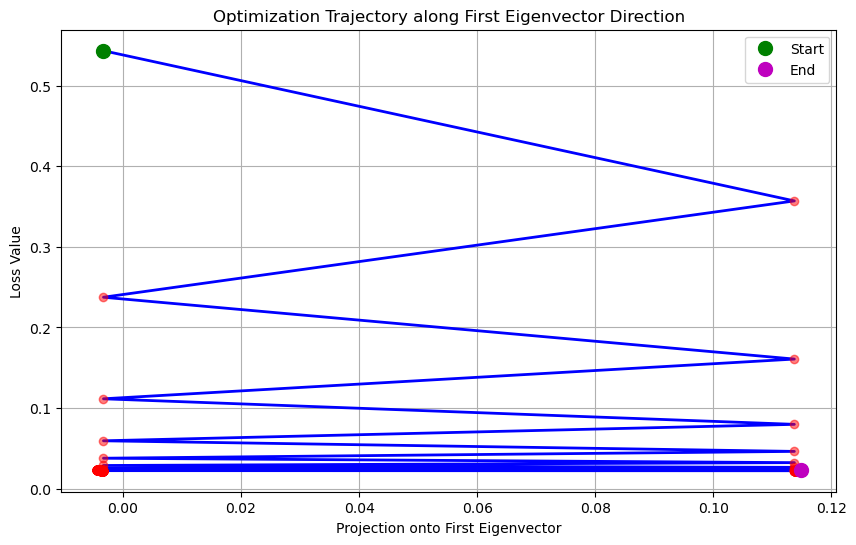

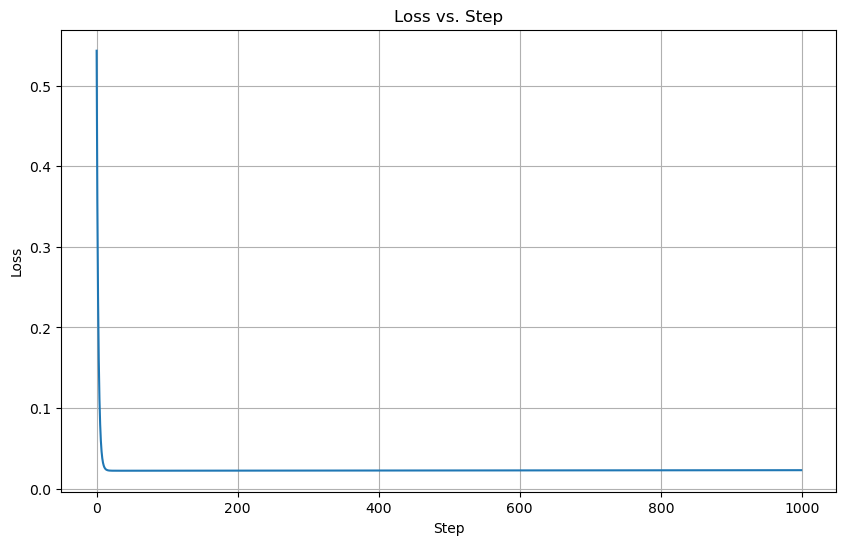

In [3]:
import numpy as np
import torch
from torch import Tensor
from scipy.sparse.linalg import LinearOperator, eigsh
import time
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Generate synthetic data
n_samples = 200000
n_features = 800

# Create a diagonal covariance matrix with decreasing values
# cov_diag = torch.linspace(10, 0.1, n_features)
cov_diag = torch.zeros(n_features)
cov_diag[0] = 10.0
step_size = (n_features - 10) / (n_features - 1)
for i in range(1, n_features):
    cov_diag[i] = step_size
cov_matrix = torch.diag(cov_diag)

# Create a multivariate normal distribution with mean 0 and our covariance matrix
mvn = torch.distributions.MultivariateNormal(
    loc=torch.zeros(n_features),
    covariance_matrix=cov_matrix
)

# Generate random normal x by sampling from the multivariate normal distribution
# This will give us a tensor of shape (n_samples, n_features)
x_data = mvn.sample((n_samples,))

# Generate a random unit vector u (the true parameter)
u_true = torch.randn(n_features)
u_true = u_true / torch.norm(u_true)

# Generate y = x^T u + epsilon
noise_level = 0.1
epsilon = noise_level * torch.randn(n_samples)
y_data = torch.matmul(x_data, u_true) + epsilon

# Compute the covariance matrix of x_data
x_cov = torch.matmul(x_data.T, x_data) / n_samples

# Compute eigenvalues and eigenvectors of the covariance matrix
eig_vals, eig_vecs = torch.linalg.eigh(x_cov)
# Sort in descending order
sorted_indices = torch.argsort(eig_vals, descending=True)
eig_vals = eig_vals[sorted_indices]
eig_vecs = eig_vecs[:, sorted_indices]

# First eigenvector (corresponding to largest eigenvalue)
first_eigenvector = eig_vecs[:, 0]

# Define the loss function
def loss_fn(y_pred, y_true):
    return torch.mean((1/2) * (y_pred - y_true) ** 2)

# Initialize model parameters randomly
model = torch.nn.Linear(n_features, 1, bias=False)
torch.nn.init.normal_(model.weight, mean=0.0, std=0.01)

# SGD optimizer without momentum
learning_rate = 2/(eig_vals[0]-0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

# Training loop - each step uses the full batch
n_steps = 1000
trajectory = []
loss_values = []

for step in range(n_steps):
    # Forward pass with full batch
    y_pred = model(x_data).squeeze()
    loss = loss_fn(y_pred, y_data)
    
    # Store loss
    loss_values.append(loss.item())
    
    # Store projection of weights onto first eigenvector
    w = model.weight.data.squeeze()
    proj = torch.dot(w, first_eigenvector)
    trajectory.append((proj.item(), loss.item()))
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step + 1) % 10 == 0:
        print(f'Step [{step+1}/{n_steps}], Loss: {loss.item():.4f}')

# Convert trajectory to numpy for plotting
trajectory = np.array(trajectory)

# Plot the trajectory along the first eigenvector
plt.figure(figsize=(10, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2)
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ro', alpha=0.5)
plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=10, label='Start')
plt.plot(trajectory[-1, 0], trajectory[-1, 1], 'mo', markersize=10, label='End')

plt.xlabel('Projection onto First Eigenvector')
plt.ylabel('Loss Value')
plt.title('Optimization Trajectory along First Eigenvector Direction')
plt.legend()
plt.grid(True)
plt.show()

# Also plot the loss curve over steps
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Step')
plt.grid(True)
plt.show()

# Below is code for more genral case where hessian is not straighforward to derive

In [ ]:

def compute_matrix_vector_product(matrix: Tensor, vector: Tensor):
    """Compute matrix-vector product for our randomly generated matrix."""
    # Ensure both tensors are on the same device
    if matrix.device != vector.device:
        vector = vector.to(matrix.device)
    return matrix @ vector

def lanczos(matrix: Tensor, neigs: int):
    """ Invoke the Lanczos algorithm to compute the leading eigenvalues and eigenvectors of a matrix.
    In this case, we directly use our randomly generated matrix rather than computing a Hessian. """
    
    dim = matrix.shape[0]
    device = matrix.device
    
    def mv(vec: np.ndarray):
        gpu_vec = torch.tensor(vec, dtype=torch.float, device=device)
        result = compute_matrix_vector_product(matrix, gpu_vec)
        return result.cpu().numpy()

    operator = LinearOperator((dim, dim), matvec=mv)
    evals, evecs = eigsh(operator, neigs)
    return torch.from_numpy(np.ascontiguousarray(evals[::-1]).copy()).float().to(device), \
           torch.from_numpy(np.ascontiguousarray(np.flip(evecs, -1)).copy()).float().to(device)

def get_matrix_eigenvalues(matrix: Tensor, neigs=3):
    """ Compute the leading eigenvalues and eigenvectors of our randomly generated matrix.
    
    Args:
        matrix: The randomly generated matrix
        neigs: Number of eigenvalues/eigenvectors to compute
        
    Returns:
        Tuple of (eigenvalues, eigenvectors)
    """
    evals, evecs = lanczos(matrix, neigs=neigs)
    return evals, evecs

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters
n = 50000  # Matrix dimension
rank = 50  # Rank of the low-rank matrix

# Create a low-rank matrix
print(f"Creating a {n}x{n} low-rank matrix with rank {rank}...")
start_time = time.time()

# Generate a random matrix on CPU or GPU depending on availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Create low-rank factors
U = torch.randn(n, rank, device=device)
matrix = U @ U.T  # This creates a symmetric positive semi-definite matrix

# Calculate eigenvalues and eigenvectors
print("\nCalculating top 3 eigenvalues and eigenvectors...")
eig_start_time = time.time()
eigenvalues, eigenvectors = get_matrix_eigenvalues(matrix, neigs=3)
eig_elapsed_time = time.time() - eig_start_time

# Print results
print(f"Eigenvalue computation completed in {eig_elapsed_time:.2f} seconds")
print("\nTop 3 eigenvalues:")
for i, val in enumerate(eigenvalues):
    print(f"λ{i+1} = {val:.6f}")

print("\nEigenvector shapes:", eigenvectors.shape)
print("First few components of the first eigenvector:", eigenvectors[:5, 0])

# Validate if they are really eigenvalues and eigenvectors
print("\nValidating eigenvalues and eigenvectors...")
for i in range(3):
    # For a valid eigenvector v with eigenvalue λ, we should have: Av ≈ λv
    v = eigenvectors[:, i].reshape(-1, 1)
    # Ensure v is on the same device as matrix
    if v.device != matrix.device:
        v = v.to(matrix.device)
    Av = matrix @ v
    lambda_v = eigenvalues[i] * v
    
    # Calculate the relative error
    error = torch.norm(Av - lambda_v) / torch.norm(lambda_v)
    
    print(f"Eigenvector {i+1} validation:")
    print(f"  Relative error: {error.item():.6e}")
    print(f"  Is valid eigenpair: {'Yes' if error < 1e-5 else 'No'}")

# Compare with torch.linalg.eigh for validation (only for small matrices)
if n <= 2000:  # Only do this for reasonably sized matrices
    print("\nComparing with torch.linalg.eigh for validation...")
    # torch.linalg.eigh returns eigenvalues in ascending order
    torch_eigenvalues, torch_eigenvectors = torch.linalg.eigh(matrix)
    # Get the top 3 eigenvalues (largest magnitude)
    top_indices = torch.argsort(torch_eigenvalues, descending=True)[:3]
    torch_top_eigenvalues = torch_eigenvalues[top_indices]
    
    print("Top 3 eigenvalues from torch.linalg.eigh:")
    for i, val in enumerate(torch_top_eigenvalues):
        print(f"λ{i+1} = {val:.6f}")
    
    # Calculate relative difference between our computed eigenvalues and torch's
    # Ensure both tensors are on the same device
    if eigenvalues.device != torch_top_eigenvalues.device:
        eigenvalues_for_comparison = eigenvalues.to(torch_top_eigenvalues.device)
    else:
        eigenvalues_for_comparison = eigenvalues
    rel_diff = torch.norm(eigenvalues_for_comparison - torch_top_eigenvalues) / torch.norm(torch_top_eigenvalues)
    print(f"Relative difference in eigenvalues: {rel_diff.item():.6e}")
    print(f"Eigenvalues match: {'Yes' if rel_diff < 1e-5 else 'No'}")

elapsed_time = time.time() - start_time
print(f"\nTotal computation completed in {elapsed_time:.2f} seconds")

